In [1]:
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import tweepy
import json
import os
from collections import Counter
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt
import time
from datetime import datetime
from dateutil.parser import parse

In [2]:
#df for cornona cases

df_corona=pd.read_csv("corona_data.csv")

#cut out first day becasue data is irregular
df_corona = df_corona.iloc[1:72]
#rename unnamed columns to Date

df_corona.rename( columns={'Unnamed: 0':'Date'}, inplace=True )
#same dates format to Climate change 
Date_list= df_corona["Date"].values
dates = []
for date in Date_list:
    dates.append(parse(date).date())
df_corona["Date"]=dates
print(df_corona)




          Date  total_cases  total_deaths  log_total_cases  log_total_deaths
1   2020-01-23          654            18         2.815578          1.255273
2   2020-01-24          941            26         2.973590          1.414973
3   2020-01-25         1434            42         3.156549          1.623249
4   2020-01-26         2118            56         3.325926          1.748188
5   2020-01-27         2927            82         3.466423          1.913814
..         ...          ...           ...              ...               ...
67  2020-03-29       720140         33925         5.857417          4.530520
68  2020-03-30       782389         37582         5.893423          4.574980
69  2020-03-31       857487         42107         5.933228          4.624354
70  2020-04-01       932605         47180         5.969698          4.673758
71  2020-04-02      1013466         52983         6.005809          4.724137

[71 rows x 5 columns]


In [20]:
#df for climate change
df_c_Change=pd.read_csv("old_climate_data.csv")
df2=df_c_Change.drop([0, 1])
df2 = df2.iloc[1:]
df2.reset_index(drop=True, inplace=True)
df2.rename( columns={'Unnamed: 0':'Date'}, inplace=True )
Date_list= df2["Date"].values
dates = []
for date in Date_list:
    dates.append(parse(date).date())
df2["Date"]=dates
df2.rename( columns={'id':'tweet_count'}, inplace=True )
df2.rename( columns={'sentiment':'pos_count'}, inplace=True )
df2.rename( columns={'sentiment.1':'neg_count'}, inplace=True )
df2.rename( columns={'sentiment.2':'neu_count'}, inplace=True )

#result = pd.concat([df_corona, df2], axis=1, join='inner')
#df for climate change
df_c_Change=pd.read_csv("old_climate_data.csv")
df2=df_c_Change.drop([0, 1])
# cut out first day
df2 = df2.iloc[1:]
df2.reset_index(drop=True, inplace=True)
df2.rename( columns={'Unnamed: 0':'Date'}, inplace=True )
Date_list= df2["Date"].values
dates = []
for date in Date_list:
    dates.append(parse(date).date())
df2["Date"]=dates
df2.rename( columns={'id':'tweet_count'}, inplace=True )
df2.rename( columns={'sentiment':'pos_count'}, inplace=True )
df2.rename( columns={'sentiment.1':'neg_count'}, inplace=True )
df2.rename( columns={'sentiment.2':'neu_count'}, inplace=True )

#result = pd.concat([df_corona, df2], axis=1, join='inner')


result = df_corona.merge(df2, on='Date')
print(result)


          Date  total_cases  total_deaths  log_total_cases  log_total_deaths  \
0   2020-01-23          654            18         2.815578          1.255273   
1   2020-01-24          941            26         2.973590          1.414973   
2   2020-01-25         1434            42         3.156549          1.623249   
3   2020-01-26         2118            56         3.325926          1.748188   
4   2020-01-27         2927            82         3.466423          1.913814   
..         ...          ...           ...              ...               ...   
66  2020-03-29       720140         33925         5.857417          4.530520   
67  2020-03-30       782389         37582         5.893423          4.574980   
68  2020-03-31       857487         42107         5.933228          4.624354   
69  2020-04-01       932605         47180         5.969698          4.673758   
70  2020-04-02      1013466         52983         6.005809          4.724137   

   tweet_count favorite_count retweet_c

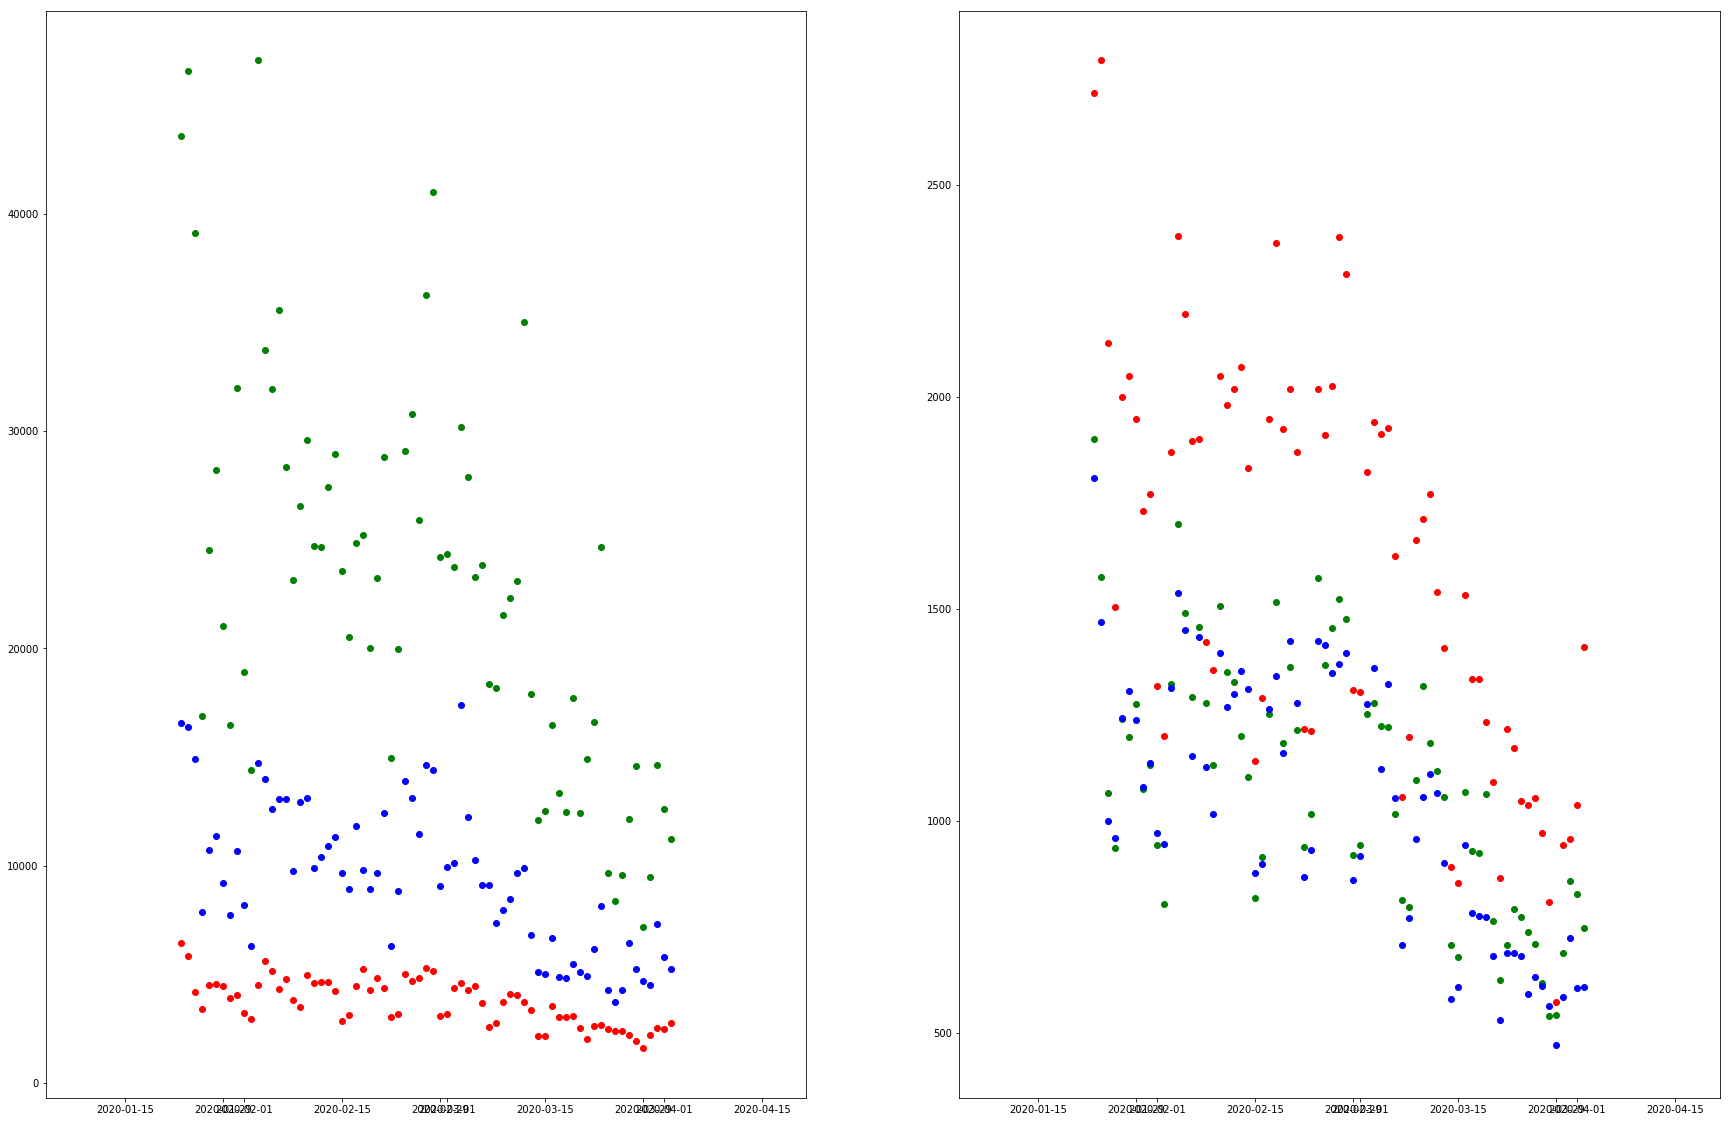

In [21]:
plt.figure(figsize=(30,20))
plt.subplot(1,2,1)
tweetid=[]
retweet_count=[]
fav_count=[]

y_colors=["red", "green", "blue"]
y_keyword=["tweet_count", "favorite_count","retweet_count"]

x_values = df2.Date
for y,c in zip(y_keyword, y_colors):
    #tweets grouped by id's
    y_values1 = list(df2[y])
    y_values1=[int(x)for x in y_values1]
    plt.scatter(x_values, y_values1, color=c, marker="o", linestyle="-") 

plt.subplot(1, 2, 2)

y_keys = ["pos_count", "neg_count","neu_count"]
for y,c in zip(y_keys, y_colors):
    #tweets grouped by id's
    y_vals = list(df2[y])
    y_vals=[int(x)for x in y_vals]    
    
    plt.scatter(x_values, y_vals, color=c, marker="o", linestyle="-")     

y_colors=["green", "black","blue", "red"]
y_keyword1=["total_cases", "total_deaths","log_total_cases", "log_total_deaths"]
  
      

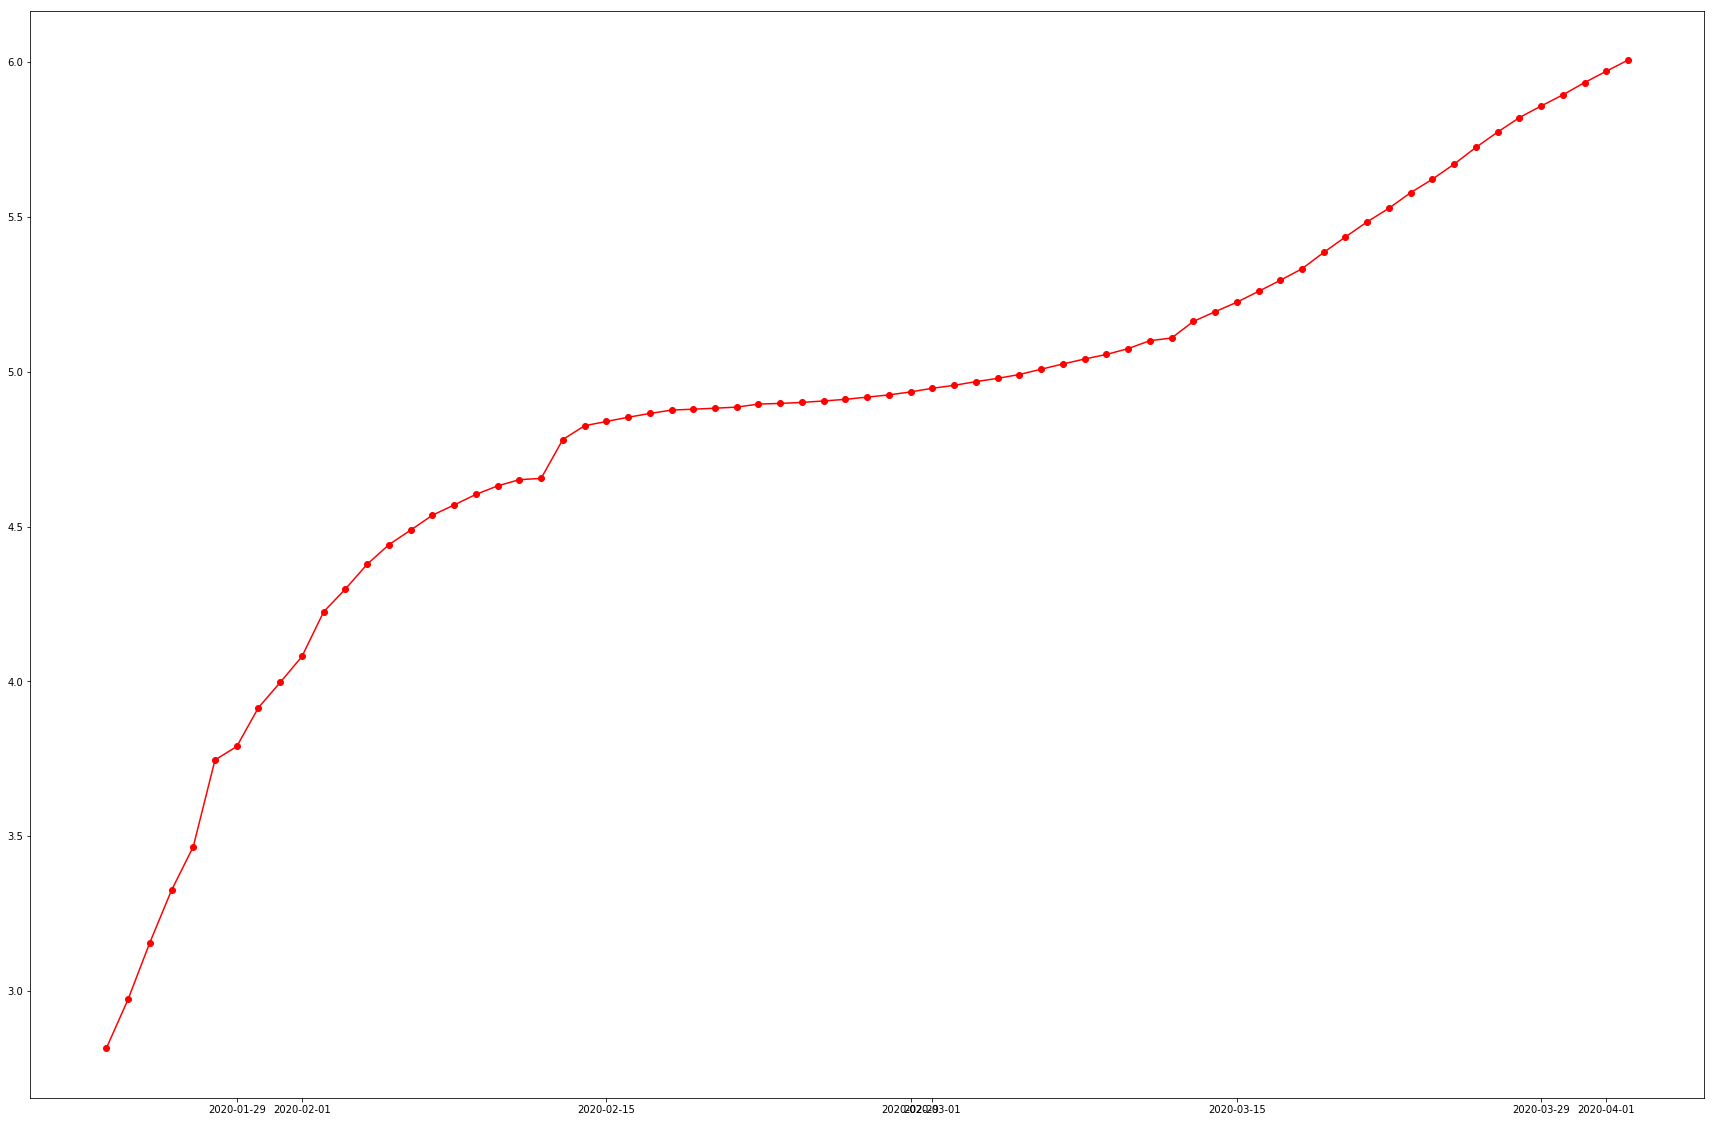

In [5]:
plt.figure(figsize=(30,20))
x_values2=df_corona.Date
#tweets grouped by id's
y_values1 = list(df_corona["log_total_cases"])
y_values1=[float(x)for x in y_values1]    

plt.plot(x_values2, y_values1, color='r', marker="o", linestyle="-") 

In [22]:
import math
import statistics

def de_mean(xs):
    x_bar = statistics.mean(xs)
    return[x-x_bar for x in xs]

def predict(alpha, beta, x_i):
    return beta*x_i+alpha

def least_squares_fit(xs, ys):
    mean_x=np.mean(xs)
    mean_y=np.mean(ys)
    de_mean_x=[x-mean_x for x in xs]
    de_mean_y=[y-mean_y for y in ys]
    covariance=np.dot(de_mean_x, de_mean_y)/(len(xs)-1)
    std_x=np.std(xs, ddof=1)
    std_y=np.std(ys, ddof=1)
    beta=covariance/std_x**2
    alpha=mean_y-beta*mean_x
    return alpha, beta

def covariance(xs, ys):
    assert len(xs) == len(ys)
    return np.dot(de_mean(xs), de_mean(ys))/(len(xs)-1)

def correlation(xs, ys):
    stdev_x = statistics.stdev(xs)
    stdev_y = statistics.stdev(ys)
    if stdev_x > 0 and stdev_y > 0:
        return covariance(xs,ys)/(stdev_x*stdev_y)
    else:
        return 0

Correlation of Covid-19 cases and tweet_count is -0.6503361804162867
Correlation of Covid-19 cases and retweet_count is -0.6274579035839667
Correlation of Covid-19 cases and favorite_count is -0.6356707528216992


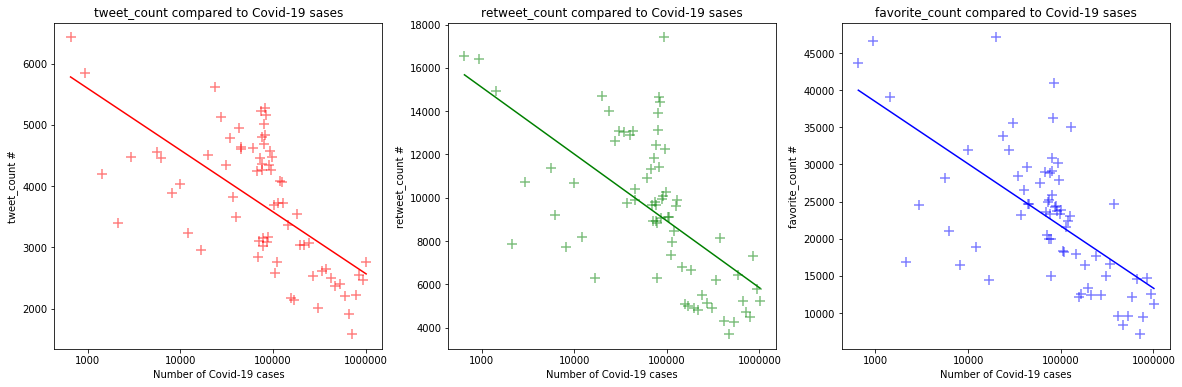

In [7]:
### log Corona cases vs twitter stats

plt.figure(figsize=(20,6))
keywords = ['tweet_count', 'retweet_count', 'favorite_count']
colors = ['red', 'green', 'blue']
y_lims = [6500, 20000, 52000]
for k in range(len(keywords)):
    plt.subplot(1,len(keywords),k+1)
    y_values = [int(y) for y in list(result[keywords[k]])]
    x_values = list(result['log_total_cases'])
    plt.title(f"{keywords[k]} compared to Covid-19 sases")
    plt.scatter(x_values, y_values,
                s=100,
                c=colors[k],
                marker="+",
                alpha=0.5)
    # Project line
    #under_x = [x_values[v] for v in range(0,len(x_values),5)]
    #under_y = [y_values[v] for v in range(0,len(y_values),5)]
    alpha, beta = least_squares_fit(x_values, y_values)
    y_predict=[predict(alpha, beta, x) for x in x_values]
    plt.plot(x_values, y_predict, colors[k])
    
    x_value_number = [3.0, 4.0, 5.0, 6.0]
    x_labels = [int(10**x) for x in x_value_number]
    plt.xticks(x_value_number, x_labels)
    plt.ylabel(f"{keywords[k]} #")
    plt.xlabel("Number of Covid-19 cases")
    print(f"Correlation of Covid-19 cases and {keywords[k]} is {correlation(x_values, y_values)}")

### NEGATIVE CORRELATION
    
    

Correlation of Covid-19 cases and tweet_count is -0.6366738043873562
Correlation of Covid-19 cases and retweet_count is -0.5929988350488448
Correlation of Covid-19 cases and favorite_count is -0.5953291655156553


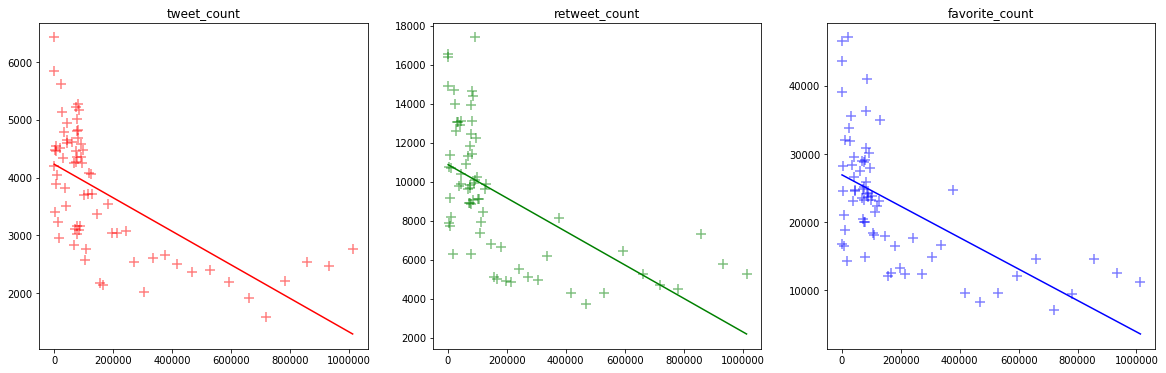

In [8]:
### Corona cases vs twitter stats (non-log, NOT HELPFUL)

plt.figure(figsize=(20,6))
keywords = ['tweet_count', 'retweet_count', 'favorite_count']
colors = ['red', 'green', 'blue']
y_lims = [6500, 20000, 52000]
for k in range(len(keywords)):
    plt.subplot(1,len(keywords),k+1)
    y_values = [int(y) for y in list(result[keywords[k]])]
    x_values = list(result['total_cases'])
    plt.title(keywords[k])
    plt.scatter(x_values, y_values,
                s=100,
                c=colors[k],
                marker="+",
                alpha=0.5)
    # Project line
    #under_x = [x_values[v] for v in range(0,len(x_values),5)]
    #under_y = [y_values[v] for v in range(0,len(y_values),5)]
    alpha, beta = least_squares_fit(x_values, y_values)
    y_predict=[predict(alpha, beta, x) for x in x_values]
    plt.plot(x_values, y_predict, colors[k])
    
    print(f"Correlation of Covid-19 cases and {keywords[k]} is {correlation(x_values, y_values)}")

Correlation of Covid-19 cases and tweet_count is -0.6664806112576098
Correlation of Covid-19 cases and retweet_count is -0.6423296584087932
Correlation of Covid-19 cases and favorite_count is -0.6450231003282848


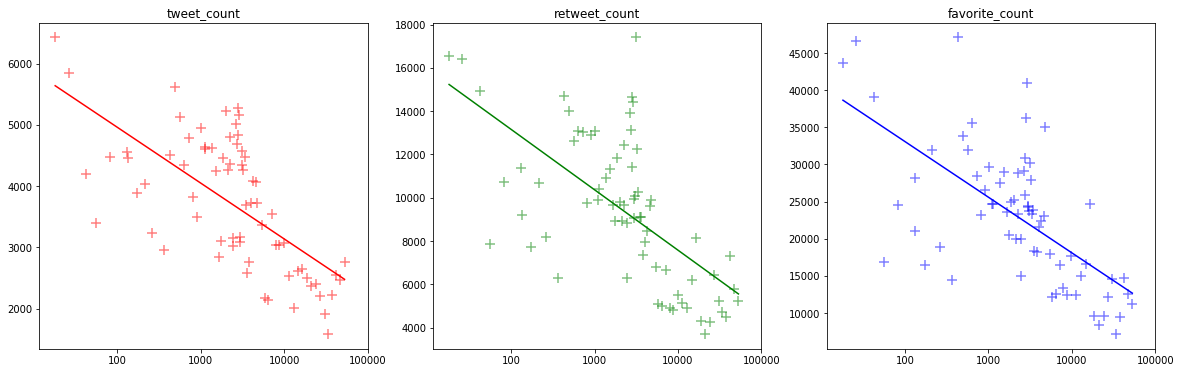

In [9]:
### Corona deaths vs twitter stats (Not Helpfull)

plt.figure(figsize=(20,6))
keywords = ['tweet_count', 'retweet_count', 'favorite_count']
colors = ['red', 'green', 'blue']
y_lims = [6500, 20000, 52000]
for k in range(len(keywords)):
    plt.subplot(1,len(keywords),k+1)
    y_values = [int(y) for y in list(result[keywords[k]])]
    x_values = list(result['log_total_deaths'])
    plt.title(keywords[k])
    plt.scatter(x_values, y_values,
                s=100,
                c=colors[k],
                marker="+",
                alpha=0.5)
    # Project line
    #under_x = [x_values[v] for v in range(0,len(x_values),5)]
    #under_y = [y_values[v] for v in range(0,len(y_values),5)]
    alpha, beta = least_squares_fit(x_values, y_values)
    y_predict=[predict(alpha, beta, x) for x in x_values]
    plt.plot(x_values, y_predict, colors[k])
    
    x_value_number = [2.0, 3.0, 4.0, 5.0]
    x_labels = [int(10**x) for x in x_value_number]
    plt.xticks(x_value_number, x_labels)
    #top = y_lims[k]
    #plt.ylim(0,top)
    print(f"Correlation of Covid-19 cases and {keywords[k]} is {correlation(x_values, y_values)}")

    

Correlation of Covid-19 cases and pos_count is -0.661851778278276
Correlation of Covid-19 cases and neg_count is -0.5861784361965259
Correlation of Covid-19 cases and neu_count is -0.6478873014299051


Text(0, 0.5, 'Number of Tweets')

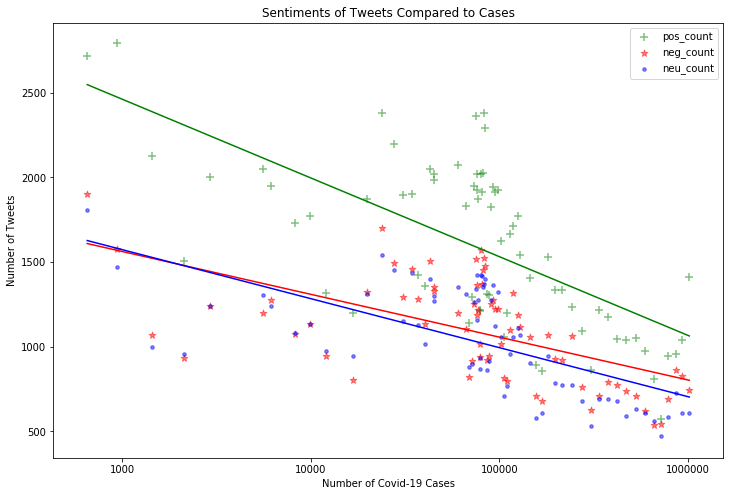

In [10]:
### pos, neg nuetral
plt.figure(figsize=(12,8))
keywords = ['pos_count', 'neg_count', 'neu_count']
colors = ['green', 'red','blue']
shapes = ['+', '*', '.']
x_values = list(result['log_total_cases'])

for k in range(len(keywords)):
    y_values = [int(y) for y in list(result[keywords[k]])]
    plt.scatter(x_values, y_values,
                s=50,
                c=colors[k],
                marker=shapes[k],
                alpha=0.5,
                label=keywords[k])
    alpha, beta = least_squares_fit(x_values, y_values)
    y_predict=[predict(alpha, beta, x) for x in x_values]
    plt.plot(x_values, y_predict, colors[k])
    
    print(f"Correlation of Covid-19 cases and {keywords[k]} is {correlation(x_values, y_values)}")

plt.title('Sentiments of Tweets Compared to Cases')
plt.legend(loc="best")
x_value_number = [3.0, 4.0, 5.0, 6.0]
x_labels = [int(10**x) for x in x_value_number]
plt.xticks(x_value_number, x_labels)
plt.xlabel("Number of Covid-19 Cases")
plt.ylabel("Number of Tweets")

In [25]:
df_c_Change=pd.read_csv("old_climate_data.csv")
df2=df_c_Change.drop([0, 1])
# cut out first day
outside_China= result.iloc[49:]
print(outside_China)




          Date  total_cases  total_deaths  log_total_cases  log_total_deaths  \
49  2020-03-12       128352          4720         5.108403          3.673942   
50  2020-03-13       145205          5404         5.161982          3.732715   
51  2020-03-14       156101          5819         5.193406          3.764848   
52  2020-03-15       167454          6440         5.223896          3.808886   
53  2020-03-16       181574          7126         5.259054          3.852846   
54  2020-03-17       197102          7905         5.294691          3.897902   
55  2020-03-18       214821          8733         5.332077          3.941163   
56  2020-03-19       242570          9867         5.384837          3.994185   
57  2020-03-20       272208         11299         5.434901          4.053040   
58  2020-03-21       304507         12973         5.483597          4.113040   
59  2020-03-22       336953         14651         5.527569          4.165867   
60  2020-03-23       378231         1650

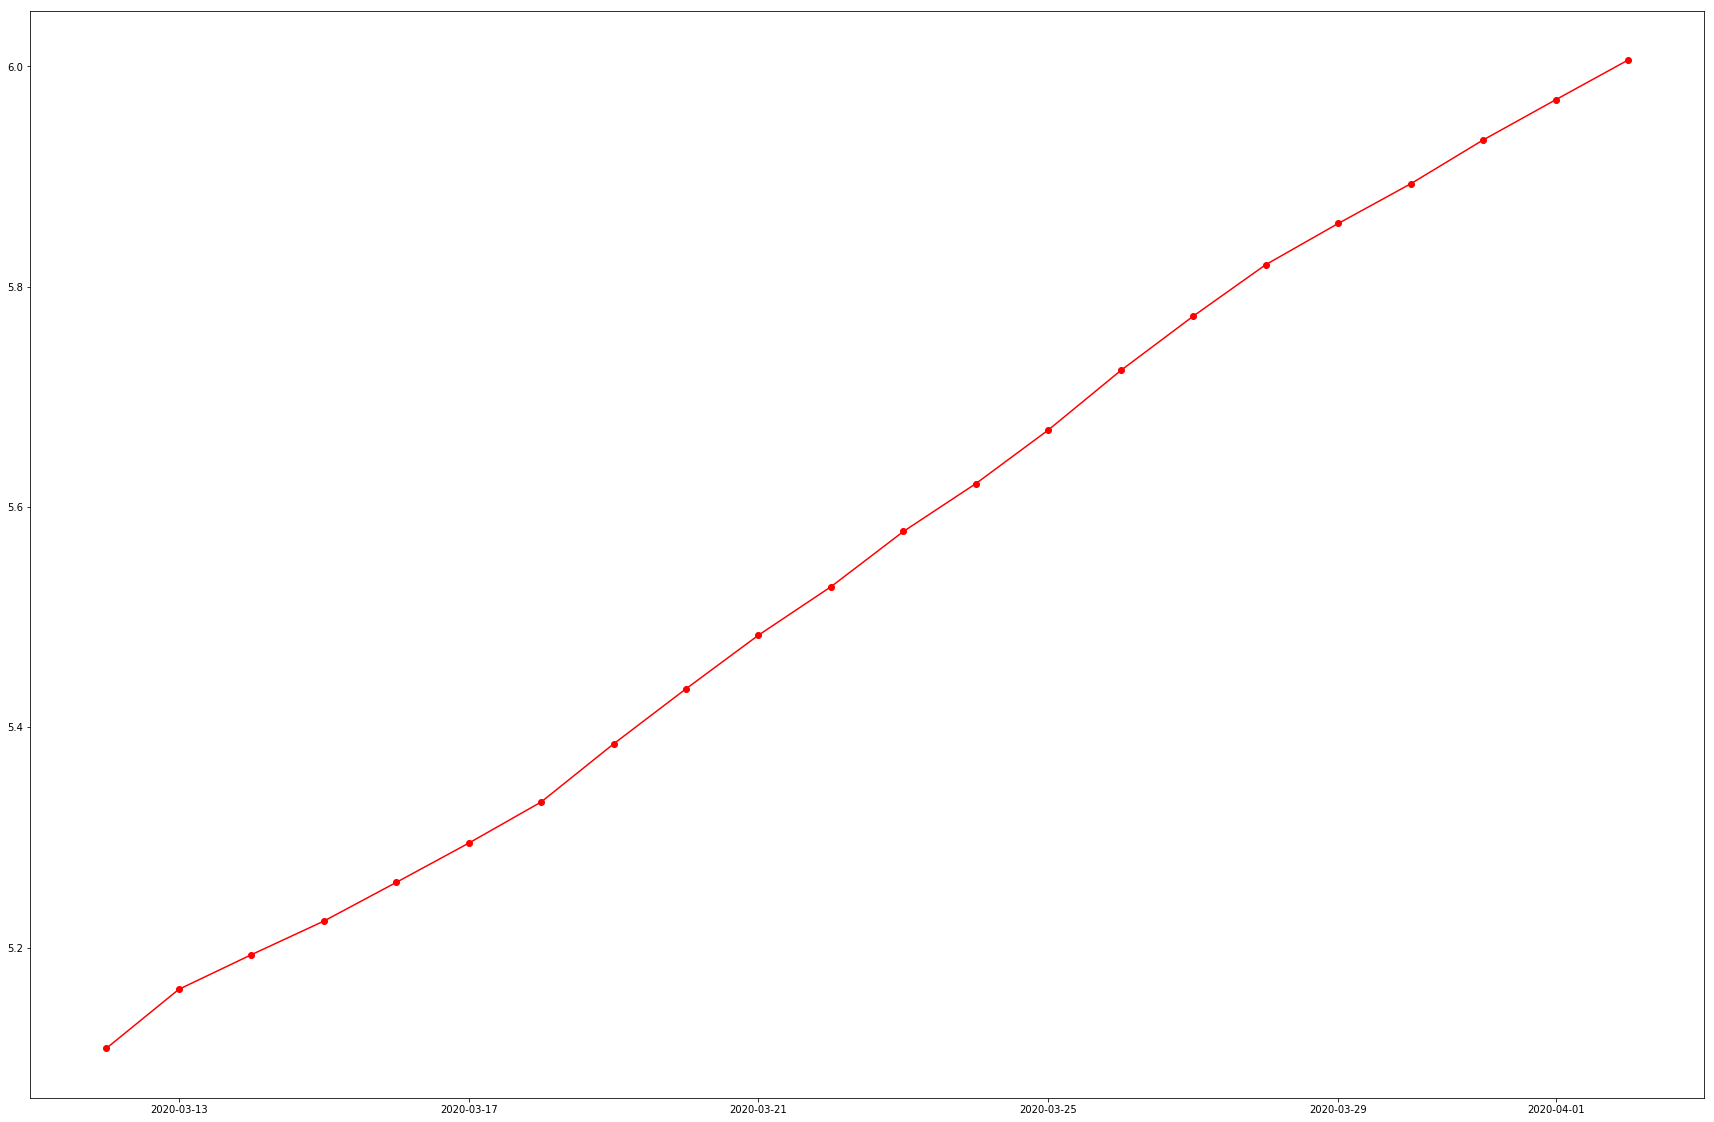

In [26]:
plt.figure(figsize=(30,20))
x_values2=outside_China.Date
#tweets grouped by id's
y_values1 = list(outside_China["log_total_cases"])
y_values1=[float(x)for x in y_values1]    

plt.plot(x_values2, y_values1, color='r', marker="o", linestyle="-") 

Correlation of Covid-19 cases and tweet_count after 3/11/2020 is -0.553804531461087
Correlation of Covid-19 cases and retweet_count after 3/11/2020 is -0.2689237083911443
Correlation of Covid-19 cases and favorite_count after 3/11/2020 is -0.4810695997062151


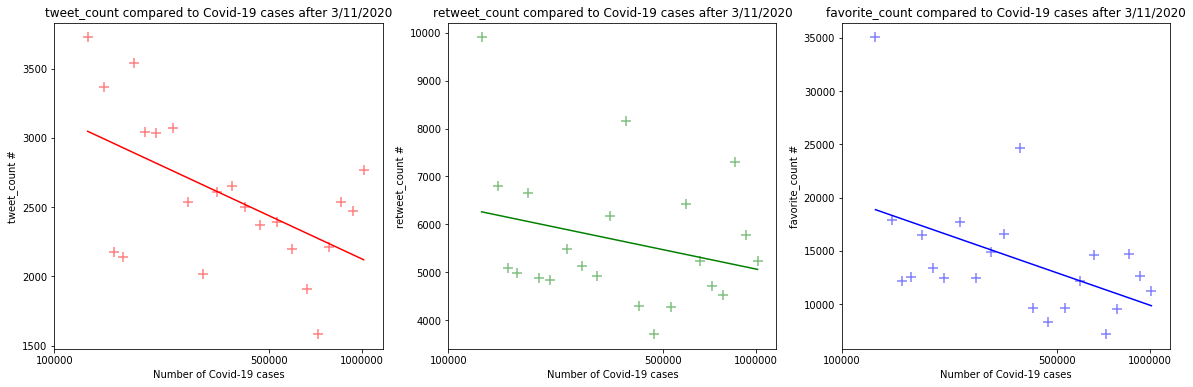

In [41]:
plt.figure(figsize=(20,6))
keywords = ['tweet_count', 'retweet_count', 'favorite_count']
colors = ['red', 'green', 'blue']
y_lims = [6500, 20000, 52000]
for k in range(len(keywords)):
    plt.subplot(1,len(keywords),k+1)
    y_values = [int(y) for y in list(outside_China[keywords[k]])]
    x_values = list(outside_China['log_total_cases'])
    plt.title(f"{keywords[k]} compared to Covid-19 cases after 3/11/2020")
    plt.scatter(x_values, y_values,
                s=100,
                c=colors[k],
                marker="+",
                alpha=0.5)
    # Project line
    #under_x = [x_values[v] for v in range(0,len(x_values),5)]
    #under_y = [y_values[v] for v in range(0,len(y_values),5)]
    alpha, beta = least_squares_fit(x_values, y_values)
    y_predict=[predict(alpha, beta, x) for x in x_values]
    plt.plot(x_values, y_predict, colors[k])
    
    x_value_number = [5.0, math.log(500001,10), 6.0]
    x_labels = [int(10**x) for x in x_value_number]
    plt.xticks(x_value_number, x_labels)
    plt.ylabel(f"{keywords[k]} #")
    plt.xlabel("Number of Covid-19 cases")
    print(f"Correlation of Covid-19 cases and {keywords[k]} after 3/11/2020 is {correlation(x_values, y_values)}")
    

Correlation of Covid-19 cases and pos_count after 3/11/2020 is -0.45227033298321373
Correlation of Covid-19 cases and neg_count after 3/11/2020 is -0.5605340712679241
Correlation of Covid-19 cases and neu_count after 3/11/2020 is -0.6234916196236657


Text(0, 0.5, 'Number of Tweets')

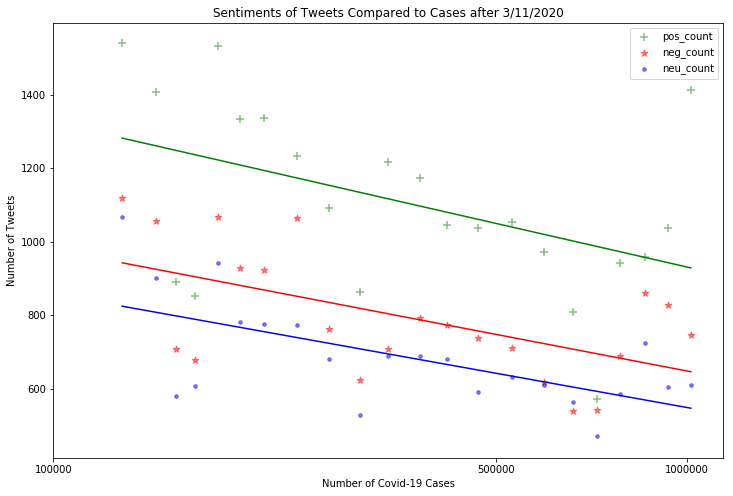

In [42]:
### pos, neg nuetral
plt.figure(figsize=(12,8))
keywords = ['pos_count', 'neg_count', 'neu_count']
colors = ['green', 'red','blue']
shapes = ['+', '*', '.']
x_values = list(outside_China['log_total_cases'])

for k in range(len(keywords)):
    y_values = [int(y) for y in list(outside_China[keywords[k]])]
    plt.scatter(x_values, y_values,
                s=50,
                c=colors[k],
                marker=shapes[k],
                alpha=0.5,
                label=keywords[k])
    alpha, beta = least_squares_fit(x_values, y_values)
    y_predict=[predict(alpha, beta, x) for x in x_values]
    plt.plot(x_values, y_predict, colors[k])
    
    print(f"Correlation of Covid-19 cases and {keywords[k]} after 3/11/2020 is {correlation(x_values, y_values)}")

plt.title('Sentiments of Tweets Compared to Cases after 3/11/2020')
plt.legend(loc="best")
x_value_number = [5.0, math.log(500001,10), 6.0]
x_labels = [int(10**x) for x in x_value_number]
plt.xticks(x_value_number, x_labels)
plt.xlabel("Number of Covid-19 Cases")
plt.ylabel("Number of Tweets")